This notebook aims to understand pheonmena on missing migrants between 2014 to early 2019 by exploring data regarding cause of death/missing of migrants and related figures.

Here below I will try to find the answers to below questions:
1. Any change in trend for migrants
2. Where are the death/missing mostly happened?
3. What caused death of migrants
4. Any implication on death rate in particular cause of death

In [455]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime

import folium
from folium.plugins import HeatMap
from folium.plugins import FastMarkerCluster
from IPython.display import HTML, display

import random

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [456]:
#read data
df0 = pd.read_csv("../input/MissingMigrants-Global-2019-03-29T18-36-07.csv")

# Index

[1. Snapshtot on data](#1.-Snapshtot-on-data)

[2. Data Cleansing](#2.-Data-Cleansing)

[3. Exploratory data analysis (EDA)](#3.-Exploratory-data-analysis-(EDA)
   * [3.1 Trend of migrants and corresponding death/missing over Time](#3.1-Trend-of-migrants-and-corresponding-death/missing-over-Time)
   * [3.2 Illustration of number of dead/missing on map](#3.2-Illustration-of-number-of-dead/missing-on-map)
   * [3.3 Cause of deaths of migrants](#3.3-Cause-of-deaths-of-migrants)
   * [3.4 Summary of death rate of top cause of death by cases count](#3.4-Summary-of-death-rate-of-top-cause-of-death-by-cases-count)

# 1. Snapshtot on data

In [457]:
df0.sample(10)

,Web ID,Region of Incident,Reported Date,Reported Year,Reported Month,Number Dead,Minimum Estimated Number of Missing,Total Dead and Missing,Number of Survivors,Number of Females,Number of Males,Number of Children,Cause of Death,Location Description,Information Source,Location Coordinates,Migration Route,URL,UNSD Geographical Grouping,Source Quality
4393,41039,Sub-Saharan Africa,"December 08, 2015",2015,Dec,7.0,NaN,7,19.0,NaN,NaN,NaN,Vehicle Accident,"highway in Bulawayo, Zimbabwe","Zegabi, IOM Zambia","-20.159104000000, 28.572376000000",NaN,http://www.zegabi.com/articles/9845,Eastern Africa,4
2910,30741,North Africa,"January 22, 2017",2017,Jan,2.0,NaN,2,NaN,NaN,NaN,NaN,Harsh conditions,"Ash Shamaliyah, Sudan",Mixed Migration Monitoring Mechanism Initiativ...,"18.904759400000, 27.846891900000",NaN,NaN,Northern Africa,2
2745,30876,US-Mexico Border,"March 21, 2017",2017,Mar,1.0,NaN,1,NaN,NaN,1.0,NaN,Unknown (skeletal remains),Pima County (see spreadsheet for exact location),Pima County Office of the Medical Examiner,"31.725322100000, -112.005521300000",Central America to US,NaN,Northern America,5
3430,42697,US-Mexico Border,"September 02, 2016",2016,Sep,1.0,NaN,1,NaN,NaN,1.0,NaN,Hit by vehicle,"Caborca, Sonora, Mexico",Nocitas Anotao,"30.722230900000, -112.176712400000",Central America to US,"http://bit.ly/2csUnsR, http://bit.ly/2c8YivE",Central America,3
4871,40922,US-Mexico Border,"July 01, 2015",2015,Jul,1.0,NaN,1,NaN,NaN,1.0,NaN,Unknown,Pima County jurisdiction,Pima County Office of the Medical Examiner,"31.621437300000, -111.930093400000",Central America to US,NaN,Northern America,5
3240,42749,Mediterranean,"October 26, 2016",2016,Oct,9.0,1.0,10,NaN,1.0,NaN,NaN,Unknown,Unspecified location between Libya and Italy,IOM Italy Reuters,"34.253371600000, 14.498815300000",Central Mediterranean,http://bit.ly/2faoSWI,Uncategorized,4
3102,42784,Central America,"December 08, 2016",2016,Dec,1.0,NaN,1,3.0,NaN,NaN,1.0,Asphyxiation,"Nogales municipality, Orizaba, Verucruz, Mexico",Noreste,"18.856444300000, -97.105878100000",Central America to US,http://bit.ly/2hEqqV7,Central America,1
725,51235,Horn of Africa,"July 28, 2018",2018,Jul,1.0,NaN,1,NaN,NaN,1.0,NaN,Shot or stabbed,"Near Negele, Ethiopia",Mixed Migration Monitoring Mechanism Initiativ...,"5.321172000000, 39.569408000000",NaN,http://www.mixedmigration.org/4mi/,Eastern Africa,2
4517,40548,Mediterranean,"October 28, 2015",2015,Oct,1.0,NaN,1,NaN,NaN,1.0,0.0,Drowning,Found on coast of Kalymnos (advanced decomposi...,Hellenic Coast Guard,"39.277258000000, 26.409536000000",Eastern Mediterranean,http://www.hcg.gr/node/11405,Uncategorized,5
152,48082,Mediterranean,"December 23, 2018",2018,Dec,NaN,2.0,2,69.0,NaN,NaN,2.0,Unknown,"Unspecified location in the Alboran Sea, bodie...","Cruz Roja Española, Caminando Fronteras","36.175539175051, -3.432980466971",Western Mediterranean,"https://bit.ly/2QrMUK7, https://bit.ly/2QtDVYL",Uncategorized,4


### Info on types of data:

In [458]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5333 entries, 0 to 5332
Data columns (total 20 columns):
Web ID                                 5333 non-null int64
Region of Incident                     5333 non-null object
Reported Date                          5333 non-null object
Reported Year                          5333 non-null int64
Reported Month                         5333 non-null object
Number Dead                            5142 non-null float64
Minimum Estimated Number of Missing    503 non-null float64
Total Dead and Missing                 5333 non-null int64
Number of Survivors                    749 non-null float64
Number of Females                      897 non-null float64
Number of Males                        2813 non-null float64
Number of Children                     644 non-null float64
Cause of Death                         5333 non-null object
Location Description                   5323 non-null object
Information Source                     5331 non-null o

Utilize only useful columns for EDA

In [459]:
df = df0[['Web ID','Region of Incident',
         'Reported Date', 
         'Total Dead and Missing',
         'Number of Survivors', 
        'Cause of Death',
        'Location Description',
        'Information Source',
        'Location Coordinates',
        'Migration Route',
        'URL','UNSD Geographical Grouping']]

## 2. Data Cleansing

Data Cleansing will involve below steps:
    1. remove duplicated rows if any
    2. inspect and treat N/A row in column 'Location Coordinates'
    3. change format of column 'Reported Date' to datetime format
    4. treat unexplanable entries(i.e. 0 victims under column 'Total Dead and Missing' but Number of Survivors is unknown )

1. Check if there are duplicated rows and remove if any

In [460]:
df[df['Web ID'].duplicated()]

,Web ID,Region of Incident,Reported Date,Total Dead and Missing,Number of Survivors,Cause of Death,Location Description,Information Source,Location Coordinates,Migration Route,URL,UNSD Geographical Grouping


2. Inspect N/A entry under column 'Location Coordinates'

In [461]:
df[df['Location Coordinates'].isna()]

,Web ID,Region of Incident,Reported Date,Total Dead and Missing,Number of Survivors,Cause of Death,Location Description,Information Source,Location Coordinates,Migration Route,URL,UNSD Geographical Grouping
2443,51450,Sub-Saharan Africa,"June 27, 2017",1,NaN,Sickness and lack of access to medicines,"Sahara Desert, Niger",Mixed Migration Monitoring Mechanism (4mi),NaN,NaN,http://www.mixedmigration.org/4mi/,Western Europe


Since there is only one row and with only 1 casualty, I will just remove the row

In [462]:
df = df[df['Location Coordinates'].notna()]

In [463]:
#also split the column for later use
df['Location Coordinates'] = df['Location Coordinates'].str.split(",")
df['Location Coordinates_lon'] = pd.to_numeric(df['Location Coordinates'].str[0][:])
df['Location Coordinates_lat'] = pd.to_numeric(df['Location Coordinates'].str[1][:])
df.drop('Location Coordinates',axis = 1)

,Web ID,Region of Incident,Reported Date,Total Dead and Missing,Number of Survivors,Cause of Death,Location Description,Information Source,Migration Route,URL,UNSD Geographical Grouping,Location Coordinates_lon,Location Coordinates_lat
0,51591,Mediterranean,"March 28, 2019",2,36.0,Presumed drowning,"Off the coast of Chios, Greece",Hellenic Coast Guard via IOM Greece,Eastern Mediterranean,NaN,Uncategorized,38.362369,26.172509
1,51588,Mediterranean,"March 26, 2019",4,11.0,Presumed drowning,"Off the coast of Ayvacık district, Çanakkale p...",Turkish Coast Guard via IOM Turkey,Eastern Mediterranean,http://bit.ly/2YmiPAN,Uncategorized,39.441976,26.378816
2,51589,Mediterranean,"March 26, 2019",1,NaN,Presumed drowning,"Body recovered on Playa del Tarajal, Ceuta, Sp...","Ceuta al día, El Pueblo de Ceuta",Western Mediterranean,"http://bit.ly/2uyj7qO, http://bit.ly/2uwj5zC",Uncategorized,35.871902,-5.343038
3,51590,Mediterranean,"March 26, 2019",1,NaN,Presumed drowning,"Body recovered on beach near Tetouan, Morocco ...",El Pueblo de Ceuta,Western Mediterranean,http://bit.ly/2uwj5zC,Uncategorized,35.635116,-5.275650
4,51587,Central America,"March 25, 2019",1,NaN,Fall from train,"Train tracks in Teacalco, Tlaxcala, Mexico","Megalópolis, Línea de contraste",NaN,"http://bit.ly/2uvDIvH, http://bit.ly/2TXAFLS",Central America,19.334475,-98.069824
5,51580,US-Mexico Border,"March 23, 2019",1,NaN,Unknown (skeletal remains),"Pima County jurisdiction, Arizona, USA",Pima County Office of the Medical Examiner,NaN,http://www.humaneborders.info/,Northern America,32.057499,-111.666072
6,51581,US-Mexico Border,"March 23, 2019",1,NaN,Unknown (skeletal remains),"Pima County jurisdiction, Arizona, USA",Pima County Office of the Medical Examiner,NaN,http://www.humaneborders.info/,Northern America,32.057499,-111.666072
7,51585,Southeast Asia,"March 23, 2019",10,NaN,Vehicle Accident,"Sa Setthi intersection in Tambon Ban Mai, Tha ...","The Nation, Vietnam+",NaN,"http://bit.ly/2YqrMsT, http://bit.ly/2TzbavA",South-eastern Asia,13.865705,99.587249
8,51586,Mediterranean,"March 23, 2019",8,NaN,Presumed drowning,"Off the coast of Sfax, Tunisia","Shems FM, Tunisie Numérique, Kapitalis",Central Mediterranean,"http://bit.ly/2U1K4C4, http://bit.ly/2HJW70B, ...",Uncategorized,35.317034,11.078928
9,51578,US-Mexico Border,"March 21, 2019",1,NaN,Unknown (skeletal remains),"Pima County jurisdiction, Arizona, USA",Pima County Office of the Medical Examiner,NaN,http://www.humaneborders.info/,Northern America,32.057499,-111.666072


3. Change 'Reported Date' column to datetime format

In [464]:
df['Reported Date'] = pd.to_datetime(df['Reported Date'], infer_datetime_format=True)

4. Inspect rows with 'Total Dead and Missing' = 0

In [465]:
df[df['Total Dead and Missing']==0]

,Web ID,Region of Incident,Reported Date,Total Dead and Missing,Number of Survivors,Cause of Death,Location Description,Information Source,Location Coordinates,Migration Route,URL,UNSD Geographical Grouping,Location Coordinates_lon,Location Coordinates_lat
2485,31060,Mediterranean,2017-06-17,0,NaN,Drowning,"Off the coast of Sabratha, Libya",UNHCR,"[32.862293600000, 12.530664000000]",Central Mediterranean,NaN,Uncategorized,32.862294,12.530664
2486,31061,Mediterranean,2017-06-17,0,NaN,Drowning,"Off the coast of Sabratha, Libya",UNHCR,"[32.862293600000, 12.530664000000]",Central Mediterranean,NaN,Uncategorized,32.862294,12.530664
3335,42715,Central America,2016-10-04,0,NaN,"Dehydration, Asphyxiation","Back of a truck, Novara, Tres Valles, Veracruz...",La Journada,"[18.268156600000, -95.896946100000]",Central America to US,http://bit.ly/2ds5sdg,Central America,18.268157,-95.896946
3572,42846,Central America,2016-07-20,0,NaN,Drowning,"Pacific Ocean; Left in boat from San Jose, Chi...",La Tribuna,"[18.268156600000, -95.896946100000]",Central America to US,http://bit.ly/2u8T36K,Central America,18.268157,-95.896946
3793,42965,Mediterranean,2016-05-25,0,NaN,Drowning,"Off the coast of Zawiya, Libya",UNHCR,"[32.761023100000, 12.699894300000]",Central Mediterranean,NaN,Uncategorized,32.761023,12.699894
3996,42959,Mediterranean,2016-03-19,0,NaN,Drowning,NaN,IOM Italy,"[33.058823123634, 17.165613325000]",Central Mediterranean,NaN,Uncategorized,33.058823,17.165613
4599,40421,Mediterranean,2015-10-10,0,NaN,Drowning,off the Egyptian port of Baltim,"IOM and Daily Star, AFP report","[31.593450985205, 31.089763608984]",Central Mediterranean,http://bit.ly/1MmKSlc,Uncategorized,31.593451,31.089764
4914,40298,North Africa,2015-06-03,0,NaN,Dehydration,Between Arlit in Niger and Algeria. 67 and 70 ...,IOM Niger,"[20.145079000000, 7.404254000000]",NaN,NaN,Northern Africa,20.145079,7.404254
4915,40300,North Africa,2015-06-03,0,NaN,Dehydration,Between Arlit in Niger and Algeria. 67 and 70 ...,IOM Niger,"[19.387730500000, 5.714761600000]",NaN,NaN,Northern Africa,19.387730,5.714762
5013,40860,Central America,2015-03-17,0,NaN,Train Accident,"Tabasco state, Mexico",South China Morning Post,"[17.947712200000, -93.680033900000]",Central America to US,http://bit.ly/1CqQVWX,Central America,17.947712,-93.680034


Fill 'Total Dead and Missing' according to information from available URL

In [466]:
df['Total Dead and Missing'][4599]=11
df['Total Dead and Missing'][5013]=6

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Drop rows that cannot be explained

In [467]:
df.drop(index=df[df['Total Dead and Missing']==0].index,inplace = True)

Add a row to sum 'Total Dead and Missing' and 'Number of Survivors'

In [468]:

df.insert(6,'Total Migrants',0)
df['Total Migrants'] = df['Total Dead and Missing']+df['Number of Survivors']

Snapshot on Dataframe after cleansing

In [469]:
df.head()

,Web ID,Region of Incident,Reported Date,Total Dead and Missing,Number of Survivors,Cause of Death,Total Migrants,Location Description,Information Source,Location Coordinates,Migration Route,URL,UNSD Geographical Grouping,Location Coordinates_lon,Location Coordinates_lat
0,51591,Mediterranean,2019-03-28,2,36.0,Presumed drowning,38.0,"Off the coast of Chios, Greece",Hellenic Coast Guard via IOM Greece,"[38.362368696592, 26.172509473654]",Eastern Mediterranean,NaN,Uncategorized,38.362369,26.172509
1,51588,Mediterranean,2019-03-26,4,11.0,Presumed drowning,15.0,"Off the coast of Ayvacık district, Çanakkale p...",Turkish Coast Guard via IOM Turkey,"[39.441975591614, 26.378816195919]",Eastern Mediterranean,http://bit.ly/2YmiPAN,Uncategorized,39.441976,26.378816
2,51589,Mediterranean,2019-03-26,1,NaN,Presumed drowning,NaN,"Body recovered on Playa del Tarajal, Ceuta, Sp...","Ceuta al día, El Pueblo de Ceuta","[35.871901875921, -5.343037665842]",Western Mediterranean,"http://bit.ly/2uyj7qO, http://bit.ly/2uwj5zC",Uncategorized,35.871902,-5.343038
3,51590,Mediterranean,2019-03-26,1,NaN,Presumed drowning,NaN,"Body recovered on beach near Tetouan, Morocco ...",El Pueblo de Ceuta,"[35.635115912988, -5.275650103548]",Western Mediterranean,http://bit.ly/2uwj5zC,Uncategorized,35.635116,-5.275650
4,51587,Central America,2019-03-25,1,NaN,Fall from train,NaN,"Train tracks in Teacalco, Tlaxcala, Mexico","Megalópolis, Línea de contraste","[19.334475177429, -98.069823987538]",NaN,"http://bit.ly/2uvDIvH, http://bit.ly/2TXAFLS",Central America,19.334475,-98.069824


*For rows with unknown 'Number of Survivors' the total migrants are still unknown

## 3.1 Trend of migrants and corresponding death/missing over Time

In [470]:
df_temp = df.groupby('Reported Date')['Total Dead and Missing'].sum().reset_index()
df_temp['Reported_Month']=df_temp['Reported Date'].dt.strftime('%Y-%m')
df_temp = df_temp.groupby('Reported_Month')['Total Dead and Missing'].sum().reset_index()

In [471]:
df_temp = df.groupby('Reported Date')['Total Dead and Missing','Total Migrants'].sum().reset_index()
df_temp['Reported_Month']=df_temp['Reported Date'].dt.strftime('%Y-%m')
df_temp = df_temp.groupby('Reported_Month')['Total Dead and Missing','Total Migrants'].sum().reset_index()

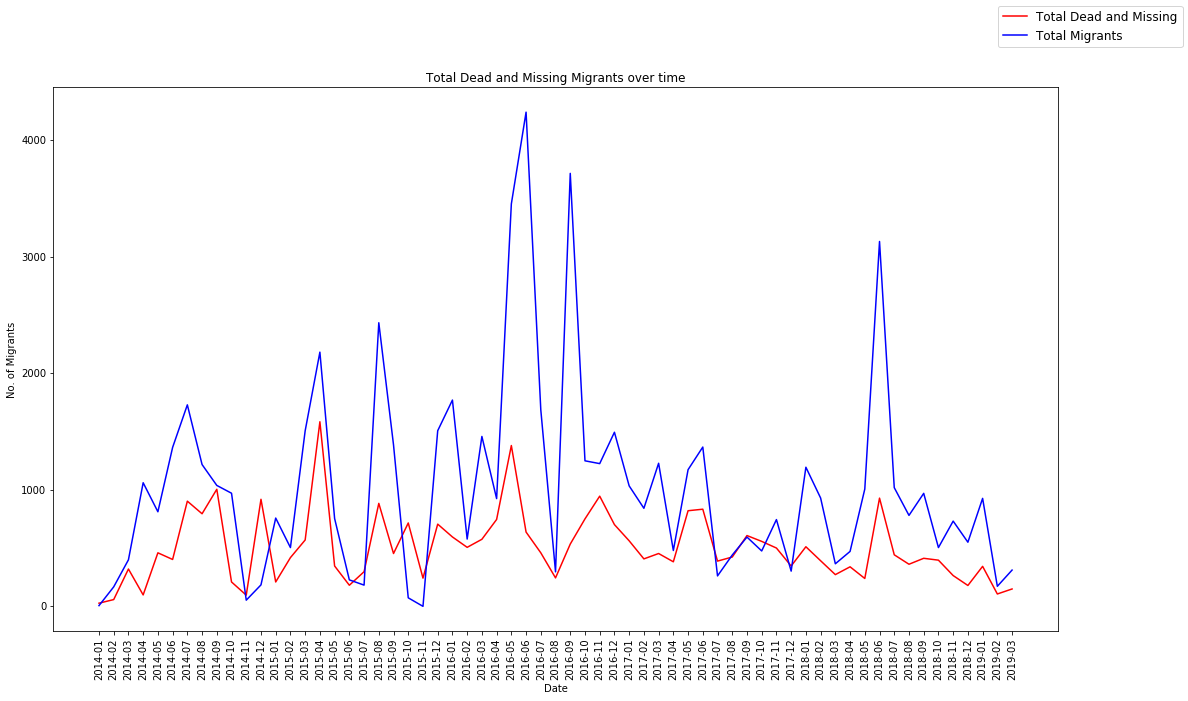

In [497]:
fig,ax =plt.subplots(figsize=(18,10));
ax = sns.lineplot(x="Reported_Month", y="Total Dead and Missing", data=df_temp, color="r").set_title('Total Dead and Missing Migrants over time');
plt.xticks(rotation='vertical');

ax2 = sns.lineplot(x="Reported_Month", y="Total Migrants", data=df_temp, color="b");

ax.figure.legend(['Total Dead and Missing','Total Migrants'],fontsize='large');

plt.xlabel('Date');
plt.ylabel('No. of Migrants');

## 3.2 Illustration of number of dead/missing on map

In [503]:
m = folium.Map(location=[30, 20], zoom_start=3)

m.add_children(HeatMap(zip(df['Location Coordinates_lon'],
                           df['Location Coordinates_lat'], 
                           df['Total Dead and Missing']),
                           min_opacity = 0.2))

FastMarkerCluster(data=list(zip(df['Location Coordinates_lon'].values, df['Location Coordinates_lat'].values))).add_to(m)
folium.LayerControl().add_to(m)


display(m)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
  


## 3.3 Cause of deaths of migrants

Here below are full list of cause of death of missing migrants:

In [481]:
df['Cause of Death'].sort_values().unique()

array(['Accident (non-vehicle)', 'Asphyxiation', 'Asphyxiation, Drowning',
       'Attacked by Apache helicopter', 'Burned', 'Burned, Drowning',
       'Bus fire', 'Cardiac arrest', 'Cervical cancer',
       'Coronary artery atherosclerosis', 'Crushed',
       'Crushed by stones (train)', 'Crushed in back of truck',
       'Crushed in back of truck, Vehicle Accident',
       'Crushed, Asphyxiation', 'Crushed, Drowning',
       'Crushed, Vehicle Accident', 'Dehydration',
       'Dehydration, Asphyxiation',
       'Dehydration, Excessive Physical Abuse',
       'Dehydration, Exposure, Hyperthermia',
       'Dehydration, Harsh conditions',
       'Dehydration, Harsh weather/lack of adequate shelter',
       'Dehydration, Harsh weather/lack of adequate shelter, Suffocation',
       'Dehydration, Harsh weather/lack of adequate shelter, Suffocation, Excessive Physical Abuse',
       'Dehydration, Hyperthermia', 'Dehydration, Shot or stabbed',
       'Dehydration, Starvation', 'Dehydration, S

### Graphic Illustration on Top cause for dead or missing vs Total migrants:

In [482]:
df_cause_of_death=df.drop(index=df[df['Total Migrants'].isna()].index)
df_cause_of_death=df_cause_of_death.groupby('Cause of Death').sum()[['Total Dead and Missing','Total Migrants']].sort_values(
    by = 'Total Dead and Missing',ascending = False).reset_index() 

In [483]:
#define sorter
sorter_cause_of_death= list(df_cause_of_death['Cause of Death'].iloc[0:30])


In [484]:
df_cause_of_death1 = pd.melt(df_cause_of_death,id_vars=['Cause of Death'],
        value_vars = ['Total Dead and Missing','Total Migrants'])
df_cause_of_death1 = df_cause_of_death1[df_cause_of_death1['Cause of Death'].isin(sorter_cause_of_death)]
#change to log value
df_cause_of_death1.rename({'value': 'Total(log10)'}, axis=1, inplace=True)
df_cause_of_death1['Total(log10)'] = np.log10(df_cause_of_death1['Total(log10)'])


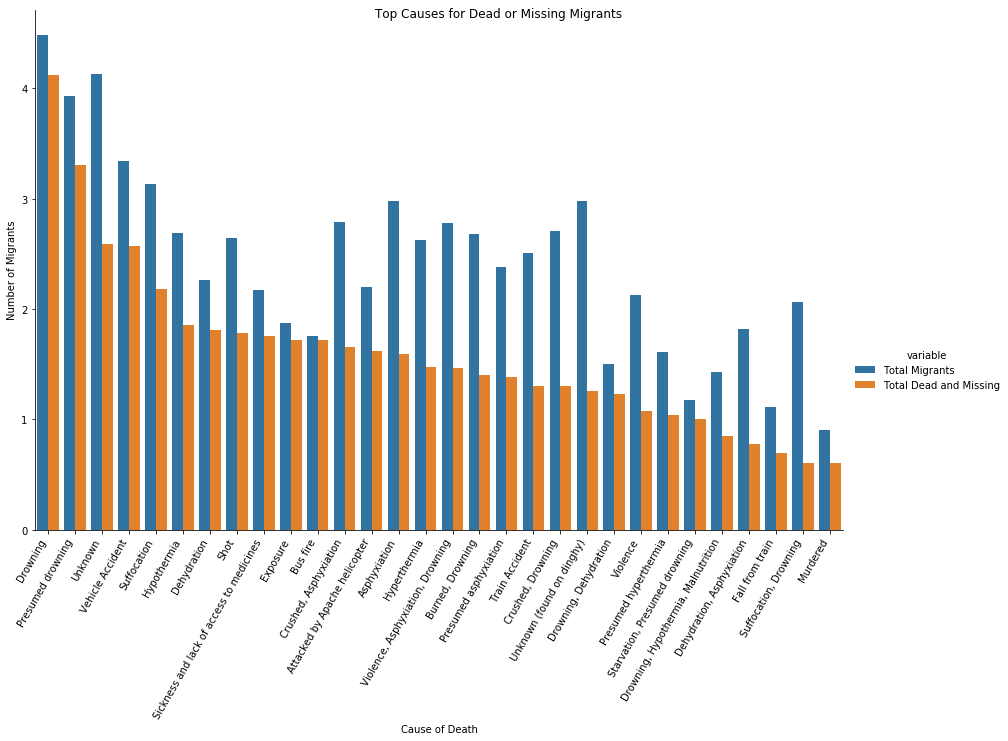

In [505]:
chart = sns.catplot(kind="bar", data = df_cause_of_death1,
            x='Cause of Death',y='Total(log10)',hue = 'variable',
            hue_order = ['Total Migrants','Total Dead and Missing'],
            order = sorter_cause_of_death, height=8,aspect = 1.5)
chart.fig.suptitle('Top Causes for Dead or Missing Migrants')

for axes in chart.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=60,horizontalalignment='right')

plt.ylabel('Number of Migrants');

### Number of Cause of Death vs Region of incidents

In [486]:
df_location = df[df['Cause of Death'].isin(sorter_cause_of_death)]

df_location1 = df_location[['Region of Incident','Cause of Death','Total Dead and Missing']]

df_location1 = df_location1.groupby(['Region of Incident','Cause of Death']).sum().unstack(level=-1)
df_location1.columns = df_location1.columns.droplevel() 
df_location1 = df_location1.fillna(0)


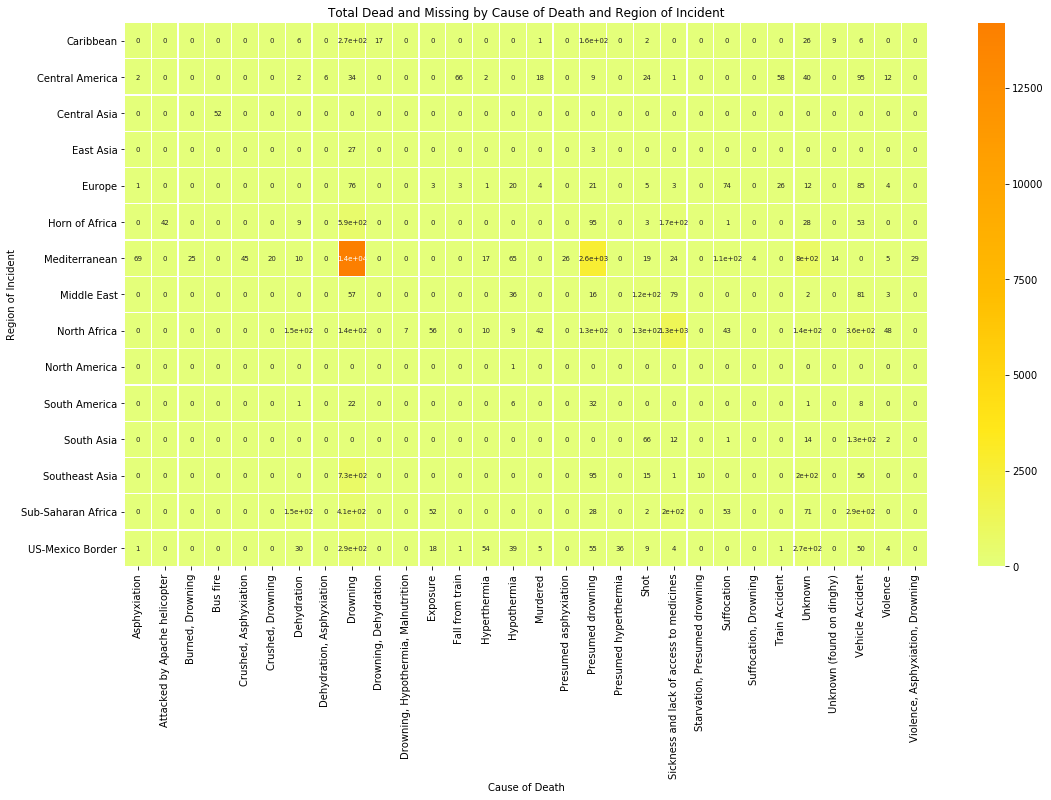

In [506]:
fig, ax = plt.subplots(figsize=(18,10));
sns.heatmap(df_location1,cmap = 'Wistia',annot=True, annot_kws={"size": 7},linewidths=0.25,ax=ax).set_title('Total Dead and Missing by Cause of Death and Region of Incident');

### Illustration on map with sampling size of 5000:

In [488]:
colors =  ['red', 'blue', 'green', 'purple', 'orange', 'darkred',
             'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue',
             'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen',
             'gray', 'black', 'lightgray']

In [523]:
m = folium.Map(location=[30, 20], zoom_start=3)

df_location2 = df_location.sample(1500)
for cause,color in zip(sorter_cause_of_death[0:15],colors):
    for x,y,z in zip(df_location2[df_location2['Cause of Death']==str(cause)]['Location Coordinates_lon'],
                     df_location2[df_location2['Cause of Death']==str(cause)]['Location Coordinates_lat'],
                     df_location2[df_location2['Cause of Death']==str(cause)]['Total Dead and Missing']):
        folium.Circle(radius=z*1000,
                  location=[x,y],
                  color = color,
                  popup='{0}, no. of death/missing: {1}'.format(cause,z),
                  fill=True).add_to(m)

display(m)

## 3.4 Summary of death rate of top cause of death by cases count

In [490]:
sorter_cause_of_death1= list(df_cause_of_death['Cause of Death'].iloc[0:15])
df_location2 = df[df['Cause of Death'].isin(sorter_cause_of_death1)]
df_location2 = df_location2[['Region of Incident','Cause of Death','Total Dead and Missing','Total Migrants']]
df_location2['Total Migrants'].fillna(df_location2['Total Dead and Missing'],inplace=True)

In [491]:
df_location2_1 = df_location2.groupby('Cause of Death').count()['Total Dead and Missing'].reset_index()
df_location2_1 = df_location2_1.rename({'Total Dead and Missing':'Count of Cases'},axis=1)
df_location2_2 = df_location2.groupby('Cause of Death').sum().reset_index()
df_location2_2 = df_location2_2.rename({'Total Dead and Missing':'Sum of Total Dead and Missing',
                                        'Total Migrants':'Sum of Total Migrants'},axis=1)
df_location2_3 = pd.merge(df_location2_2,df_location2_1,on=['Cause of Death'],how='left')

In [492]:
df_location2_3.sort_values(by = 'Sum of Total Dead and Missing', ascending = False)

,Cause of Death,Sum of Total Dead and Missing,Sum of Total Migrants,Count of Cases
5,Drowning,16863,34338.0,963
9,Presumed drowning,3266,9724.0,347
11,Sickness and lack of access to medicines,1838,1929.0,756
13,Unknown,1592,14600.0,549
14,Vehicle Accident,1210,3006.0,444
10,Shot,391,769.0,171
4,Dehydration,352,473.0,119
12,Suffocation,278,1496.0,36
8,Hypothermia,176,591.0,79
6,Exposure,129,152.0,21


In [493]:
df_location2_3['Sum of Total Dead and Missing'] = np.log10(df_location2_3['Sum of Total Dead and Missing'])
df_location2_3['Sum of Total Migrants'] = np.log10(df_location2_3['Sum of Total Migrants'])
df_location2_3.rename({'Sum of Total Dead and Missing':'Sum of Total Dead and Missing(log10)','Sum of Total Migrants':'Sum of Total Migrants(log10)' },axis=1,inplace=True)

### Visualized explanation

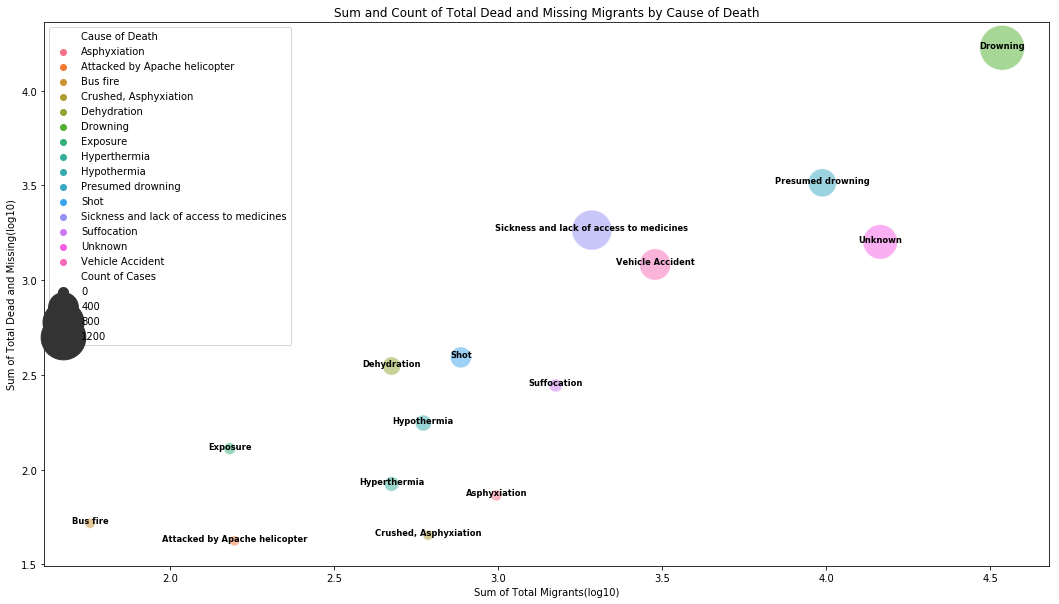

In [494]:
fig, ax = plt.subplots(figsize=(18,10));
ax = sns.scatterplot(x="Sum of Total Migrants(log10)", y="Sum of Total Dead and Missing(log10)",
                     hue="Cause of Death", size="Count of Cases", 
                     sizes=(100, 2000),alpha = 0.5,legend='brief',data=df_location2_3)

for line in range(0,df_location2_3.shape[0]):
     ax.text(x=df_location2_3['Sum of Total Migrants(log10)'][line],
             y= df_location2_3['Sum of Total Dead and Missing(log10)'][line],
             s=df_location2_3['Cause of Death'][line],
             horizontalalignment='center', size='small', color='black', weight='semibold',linespacing=5)
ax.set_title('Sum and Count of Total Dead and Missing Migrants by Cause of Death');

* Causes with high gradient means higher death rate(e.g. easier to cause death by Dehydration than Asphyxiation)